# importing libraries

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import pickle

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from PIL import Image

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install Pillow==7.2.0


In [ ]:
!pip install -U pip
!pip install git+https://github.com/cleanlab/cleanvision.git
!pip install --upgrade Pillow

In [ ]:
from cleanvision.imagelab import Imagelab

# Connecting to Google Driving

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


# Train, Test, Split Images

In [5]:
# set up paths to the image folders
data_dir = 'Final_Project/cell_images'
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# get a list of all the image filenames
parasitized_images = os.listdir(parasitized_dir)
uninfected_images = os.listdir(uninfected_dir)

# create a list of all the image paths
image_paths = []
for img in parasitized_images:
    image_paths.append(os.path.join(parasitized_dir, img))
for img in uninfected_images:
    image_paths.append(os.path.join(uninfected_dir, img))

# create an array of labels (0 for uninfected, 1 for parasitized)
labels = np.zeros(len(image_paths))
labels[:len(parasitized_images)] = 1

# split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


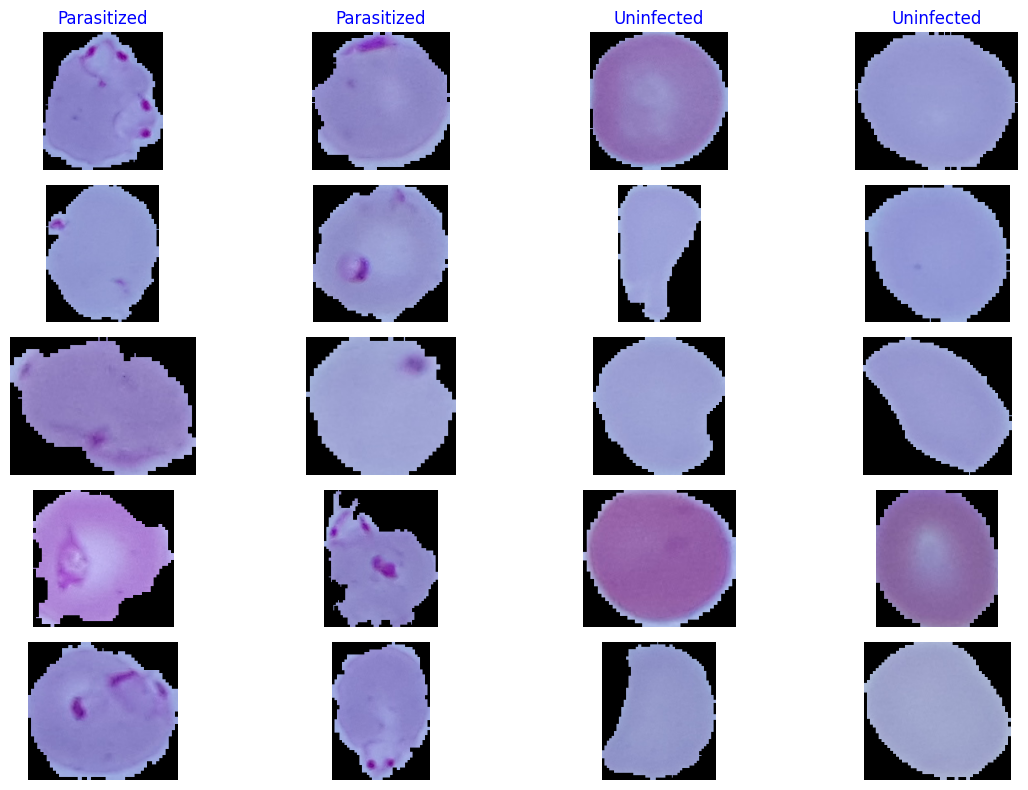

In [ ]:
# Visualizing Data

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))

# Display 10 parasitized images on the left and 10 Uninfected images on the right
for i in range(5):
    axs[i, 0].imshow(cv2.imread(image_paths[i]))
    axs[i, 0].axis('off')

for i in range(5, 10):
    axs[i - 5, 1].imshow(cv2.imread(image_paths[i]))
    axs[i - 5, 1].axis('off')

for i in range(5):
  axs[i, 2].imshow(cv2.imread(image_paths[-10 + i]))
  axs[i, 2].axis('off')


for i in range(5, 10):
  axs[i - 5, 3].imshow(cv2.imread(image_paths[-10 + i]))
  axs[i - 5, 3].axis('off')

# Add labels for the first and last images
axs[0, 0].set_title("Parasitized", color= 'blue', fontsize= 12, loc = "center")
axs[0, 1].set_title("Parasitized", color= 'blue', fontsize= 12, loc = "center")
axs[0, 2].set_title("Uninfected", color= 'blue', fontsize= 12, loc = "center")
axs[0, 3].set_title("Uninfected", color= 'blue', fontsize= 12, loc = "center")

plt.tight_layout()

plt.show()



In [ ]:
directories = {'Class_0': uninfected_dir,
'Class_1': parasitized_dir}

'''Returns dimenstions for an RBG image'''
def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w


In [ ]:
dim = get_dims(image_paths[0])
dim
list = []
list.append(dim)
list

[(160, 139)]

In [ ]:
len(image_paths)

27560

In [ ]:
dim_list = []
for i in range(len(image_paths)):
  image_paths1 = image_paths[i]
  if image_paths1 == 'Final_Project/cell_images/Parasitized/Thumbs.db':
    pass
  elif image_paths1 == 'Final_Project/cell_images/Uninfected/Thumbs.db':
    pass
  else:
    dimensions = get_dims(image_paths1)
    dim_list.append(dimensions)


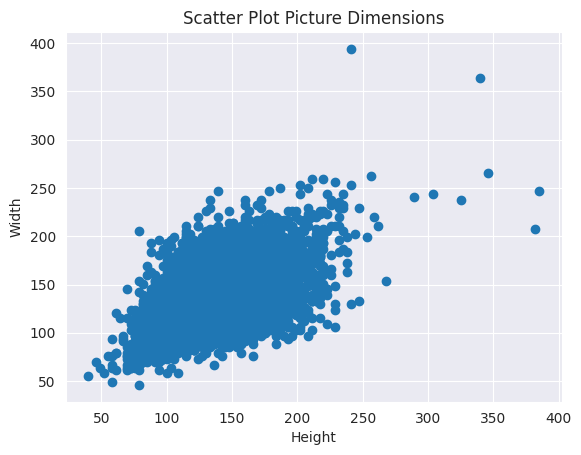

In [ ]:
#make graph looking at dimensions
x_vals = [coord[0] for coord in dim_list]
y_vals = [coord[1] for coord in dim_list]

# create the scatter plot
plt.scatter(x_vals, y_vals)

# set the plot title and axis labels
plt.title('Scatter Plot Picture Dimensions')
plt.xlabel('Height')
plt.ylabel('Width')

# display the plot
plt.show()

The graph above shows that the image files that are in my two image directories are all different sizes. I will make them all 128 by 128 pixels

In [6]:
train_labels = [str(i) for i in train_labels]
test_labels = [str(i) for i in test_labels]

In [7]:
# create a dataframe with the image file paths and corresponding labels
df_train = pd.DataFrame({
    'file_path': train_images,  # a list of image file paths
    'label': train_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (224, 224)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_train = data_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 22047 validated image filenames belonging to 2 classes.


In [ ]:
# generate all the images and labels in numpy array format
num_samples = len(data_generator_train.filenames)
images_array = []
labels_array = []

for i in range(num_samples // 32):
    batch_images, batch_labels = data_generator_train.next()
    start_idx = i * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

# process any remaining images if batch_size doesn't evenly divide into num_samples
if num_samples % 32 > 0:
    batch_images, batch_labels = data_generator_train.next()
    start_idx = (num_samples // 32) * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

In [ ]:
image_frame = pd.DataFrame({
    'image': images_array,
    'label': labels_array})

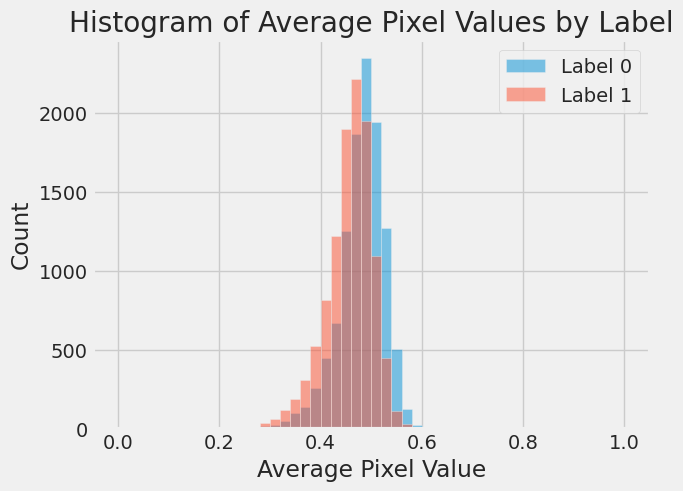

In [ ]:
#image pixel density

# Calculate the average pixel value for each group separately
average_pixel_values_0 = [np.mean(image) for image in image_frame[image_frame['label'] == 0]['image']]
average_pixel_values_1 = [np.mean(image) for image in image_frame[image_frame['label'] == 1]['image']]

# Plot a histogram of the average pixel values for each group
plt.hist(average_pixel_values_0, bins=50, range=(0, 1), alpha=0.5, label='Label 0')
plt.hist(average_pixel_values_1, bins=50, range=(0, 1), alpha=0.5, label='Label 1')

# Set the title and axis labels
plt.title("Histogram of Average Pixel Values by Label")
plt.xlabel("Average Pixel Value")
plt.ylabel("Count")

# Add a legend
plt.legend()

# Show the plot
plt.show()



In [ ]:
# Check Class Balance
train_labels, train_counts = np.unique(data_generator_train.classes, return_counts = True)
train_counts

array([11030, 11017])

In [8]:
# create a dataframe with the image file paths and corresponding labels
df_test = pd.DataFrame({
    'file_path': test_images,  # a list of image file paths
    'label': test_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (224, 224)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_test = data_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

Found 5511 validated image filenames belonging to 2 classes.


In [ ]:
# generate all the images and labels in numpy array format
num_samples = len(data_generator_test.filenames)
images_array_test = []
labels_array_test = []

for i in range(num_samples // 32):
    batch_images, batch_labels = data_generator_test.next()
    start_idx = i * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

# process any remaining images if batch_size doesn't evenly divide into num_samples
if num_samples % 32 > 0:
    batch_images, batch_labels = data_generator_test.next()
    start_idx = (num_samples // 32) * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

In [ ]:
test_labels, test_counts = np.unique(data_generator_test.classes, return_counts = True)
test_counts

array([2749, 2762])

# EDA


In [ ]:
# Clean Photos
imagelab_para = Imagelab(data_path=parasitized_dir)
imagelab_para.find_issues()


Reading images from /content/drive/MyDrive/Final_Project/cell_images/Parasitized
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 13779/13779 [00:48<00:00, 285.78it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().


In [ ]:
imagelab_para.report()

No issues found.


In [ ]:
imagelab_unin = Imagelab(data_path=uninfected_dir)
imagelab_unin.find_issues()

Reading images from /content/drive/MyDrive/Final_Project/cell_images/Uninfected
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 13779/13779 [00:56<00:00, 242.96it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().


Issues found in order of severity in the dataset

|    | issue_type      |   num_images |
|---:|:----------------|-------------:|
|  0 | near_duplicates |            2 | 

Found 1 set of images with near_duplicates issue in the dataset.
Set: 0


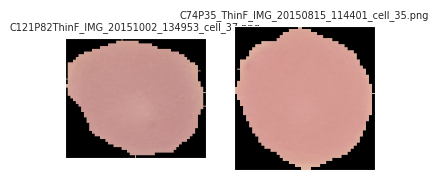

In [ ]:
imagelab_unin.report()

The imagelab reports show that there are no blurry, blank or corrupted images in either directory. Now that I know that the images are of a good quality, I will...

# Creating CNN

### Model 1

In [9]:
#instantiate a model
base_model = Sequential()


# add the input layer  
base_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224, 224, 3)))


# max pool in 2x2 window
base_model.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
base_model.add(Flatten())
base_model.add(Dense(32, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
base_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])


In [10]:
history_base = base_model.fit(data_generator_train, steps_per_epoch = 20, epochs = 10)

Epoch 1/10
20/20 [==============================] - 422s 21s/step - loss: 2.4759 - accuracy: 0.4891
Epoch 2/10
20/20 [==============================] - 405s 20s/step - loss: 0.6931 - accuracy: 0.5063
Epoch 3/10
20/20 [==============================] - 384s 19s/step - loss: 0.6932 - accuracy: 0.4828
Epoch 4/10
20/20 [==============================] - 373s 19s/step - loss: 0.6935 - accuracy: 0.4984
Epoch 5/10
20/20 [==============================] - 365s 18s/step - loss: 0.7386 - accuracy: 0.5328
Epoch 6/10
20/20 [==============================] - 350s 17s/step - loss: 0.6932 - accuracy: 0.4984
Epoch 7/10
20/20 [==============================] - 342s 17s/step - loss: 0.6932 - accuracy: 0.4953
Epoch 8/10
20/20 [==============================] - 342s 17s/step - loss: 0.6931 - accuracy: 0.5047
Epoch 9/10
20/20 [==============================] - 328s 16s/step - loss: 0.6932 - accuracy: 0.4984
Epoch 10/10
20/20 [==============================] - 311s 16s/step - loss: 0.6931 - accuracy: 0.5094

### Model 2: Adding additional Layers

In [ ]:
#instantiate a model
model_2 = Sequential()


# add the input layer  
model_2.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2 = model_2.fit(data_generator_train, steps_per_epoch = 20, epochs = 10)

Epoch 1/10
20/20 [==============================] - 62s 3s/step - loss: 0.6994 - accuracy: 0.5109
Epoch 2/10
20/20 [==============================] - 56s 3s/step - loss: 0.6925 - accuracy: 0.5203
Epoch 3/10
20/20 [==============================] - 53s 3s/step - loss: 0.6672 - accuracy: 0.6266
Epoch 4/10
20/20 [==============================] - 57s 3s/step - loss: 0.5668 - accuracy: 0.7266
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 0.4505 - accuracy: 0.8562
Epoch 6/10
20/20 [==============================] - 48s 2s/step - loss: 0.4418 - accuracy: 0.8797
Epoch 7/10
20/20 [==============================] - 57s 3s/step - loss: 0.4874 - accuracy: 0.7625
Epoch 8/10
20/20 [==============================] - 50s 2s/step - loss: 0.2869 - accuracy: 0.9047
Epoch 9/10
20/20 [==============================] - 52s 2s/step - loss: 0.2171 - accuracy: 0.9281
Epoch 10/10
20/20 [==============================] - 43s 2s/step - loss: 0.2120 - accuracy: 0.9406


### Model 2.5: Increasings epochs and callback use

In [11]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = early_stopping

In [ ]:
#instantiate a model
model_2_5 = Sequential()


# add the input layer  
model_2_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2_5.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2_5.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2_5.add(Flatten())
model_2_5.add(Dense(32, activation='relu'))
model_2_5.add(Dense(32, activation='relu'))
model_2_5.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2_5.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2_5 = model_2_5.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 35s 2s/step - loss: 0.6941 - accuracy: 0.5281
Epoch 2/40
20/20 [==============================] - 32s 2s/step - loss: 0.6932 - accuracy: 0.5125
Epoch 3/40
20/20 [==============================] - 32s 2s/step - loss: 0.6939 - accuracy: 0.4969
Epoch 4/40
20/20 [==============================] - 32s 2s/step - loss: 0.6928 - accuracy: 0.5406
Epoch 5/40
20/20 [==============================] - 32s 2s/step - loss: 0.6939 - accuracy: 0.5203
Epoch 6/40
20/20 [==============================] - 33s 2s/step - loss: 0.6931 - accuracy: 0.4969
Epoch 7/40
20/20 [==============================] - 32s 2s/step - loss: 0.6910 - accuracy: 0.5344
Epoch 8/40
20/20 [==============================] - 32s 2s/step - loss: 0.6735 - accuracy: 0.5766
Epoch 9/40
20/20 [==============================] - 32s 2s/step - loss: 0.6775 - accuracy: 0.5484
Epoch 10/40
20/20 [==============================] - 32s 2s/step - loss: 0.6050 - accuracy: 0.6625
Epoch 11/40
20/20 [

In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_2_5.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

173/173 - 80s - loss: 0.1873 - accuracy: 0.9401 - 80s/epoch - 461ms/step
0.18725353479385376 0.940119743347168


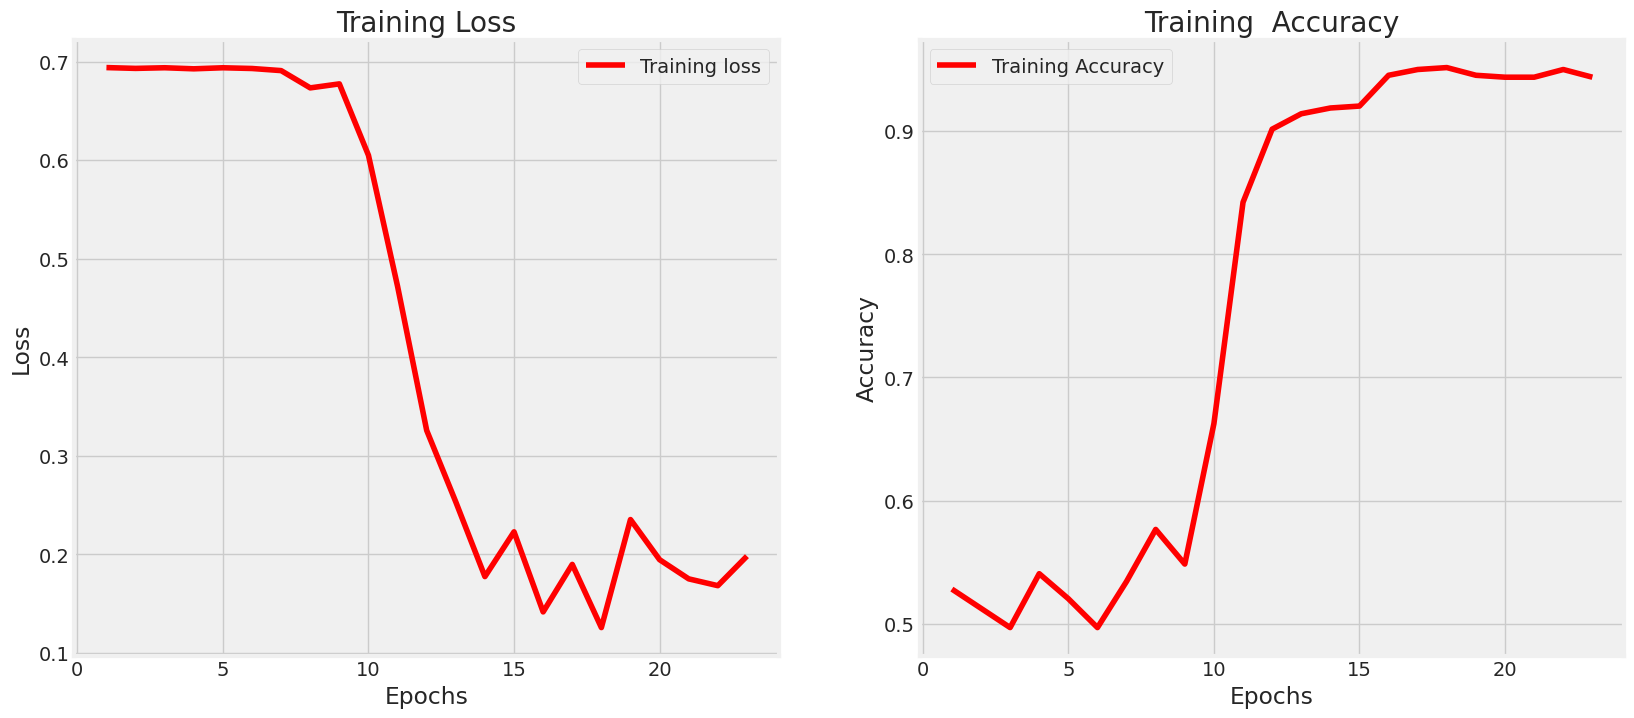

In [ ]:
# Define needed variables
tr_acc = history_model_2_5.history['accuracy']
tr_loss = history_model_2_5.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

#put these on the same axis

In [ ]:
y_proba = model_2_5.predict(data_generator_test) 

173/173 [==============================] - 82s 472ms/step


In [ ]:
y_pred = (y_proba > 0.5).astype('int')

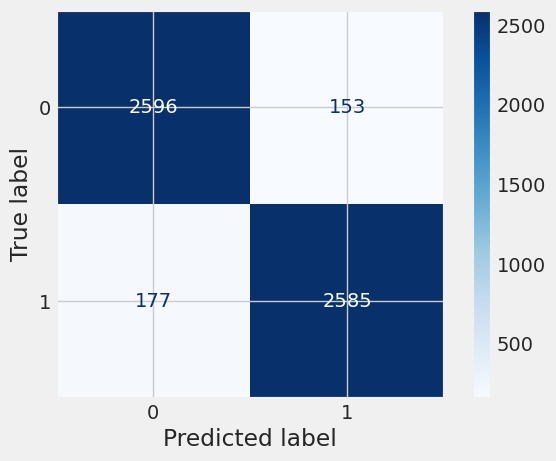

In [ ]:
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model 2.75: Changing Callback Parameters

In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
callbacks2 = early_stopping

In [ ]:
#instantiate a model
model_2_75 = Sequential()


# add the input layer  
model_2_75.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2_75.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2_75.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2_75.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2_75.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2_75.add(Flatten())
model_2_75.add(Dense(32, activation='relu'))
model_2_75.add(Dense(32, activation='relu'))
model_2_75.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2_75.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2_75 = model_2_75.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks2, epochs = 40)

Epoch 1/40
20/20 [==============================] - 32s 2s/step - loss: 0.6930 - accuracy: 0.5266
Epoch 2/40
20/20 [==============================] - 34s 2s/step - loss: 0.6990 - accuracy: 0.5656
Epoch 3/40
20/20 [==============================] - 34s 2s/step - loss: 0.6609 - accuracy: 0.6547
Epoch 4/40
20/20 [==============================] - 32s 2s/step - loss: 0.5478 - accuracy: 0.7531
Epoch 5/40
20/20 [==============================] - 32s 2s/step - loss: 0.3826 - accuracy: 0.8531
Epoch 6/40
20/20 [==============================] - 32s 2s/step - loss: 0.2754 - accuracy: 0.8781
Epoch 7/40
20/20 [==============================] - 31s 2s/step - loss: 0.2618 - accuracy: 0.9062
Epoch 8/40
20/20 [==============================] - 31s 2s/step - loss: 0.2012 - accuracy: 0.9344
Epoch 9/40
20/20 [==============================] - 31s 1s/step - loss: 0.2041 - accuracy: 0.9422
Epoch 10/40
20/20 [==============================] - 32s 2s/step - loss: 0.1398 - accuracy: 0.9516
Epoch 11/40
20/20 [

### Model 3: Adding Dense Layers

In [17]:
#instantiate a model
model_3 = Sequential()


# add the input layer  
model_3.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224, 224, 3)))
# max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_3.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

# add second max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_3.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

# add third max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_3.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

# add fourth max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_3.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

# add fifth max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [18]:
history_model_3 = model_3.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 176s 9s/step - loss: 0.7171 - accuracy: 0.4891
Epoch 2/40
20/20 [==============================] - 175s 9s/step - loss: 0.6931 - accuracy: 0.4859
Epoch 3/40
20/20 [==============================] - 166s 8s/step - loss: 0.6936 - accuracy: 0.4797
Epoch 4/40
20/20 [==============================] - 170s 8s/step - loss: 0.6933 - accuracy: 0.4844
Epoch 5/40
20/20 [==============================] - 172s 9s/step - loss: 0.6932 - accuracy: 0.4656
Epoch 6/40
20/20 [==============================] - 165s 8s/step - loss: 0.6932 - accuracy: 0.4781
Epoch 7/40
20/20 [==============================] - 155s 8s/step - loss: 0.6932 - accuracy: 0.4859


### Model 4: With Batch Normalization

In [19]:
#instantiate a model
model_4 = Sequential()


# add the input layer  
model_4.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224, 224, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_4.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_4.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_4.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_4.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_4.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [20]:
history_model_4 = model_4.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 154s 8s/step - loss: 0.6948 - accuracy: 0.5203
Epoch 2/40
20/20 [==============================] - 130s 6s/step - loss: 0.6907 - accuracy: 0.5531
Epoch 3/40
20/20 [==============================] - 150s 7s/step - loss: 0.6701 - accuracy: 0.6750
Epoch 4/40
20/20 [==============================] - 134s 7s/step - loss: 0.6990 - accuracy: 0.4969
Epoch 5/40
20/20 [==============================] - 125s 6s/step - loss: 0.6838 - accuracy: 0.6078
Epoch 6/40
20/20 [==============================] - 115s 6s/step - loss: 0.5057 - accuracy: 0.8188
Epoch 7/40
20/20 [==============================] - 118s 6s/step - loss: 0.3224 - accuracy: 0.8828
Epoch 8/40
20/20 [==============================] - 109s 6s/step - loss: 0.2837 - accuracy: 0.9406
Epoch 9/40
20/20 [==============================] - 107s 5s/step - loss: 0.1984 - accuracy: 0.9438
Epoch 10/40
20/20 [==============================] - 106s 5s/step - loss: 0.1929 - accuracy: 0.9422
Epoch 11/

In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_4.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

### Model 5: Adding Additional Layers and Padding



In [21]:
#instantiate a model
model_5 = Sequential()


# add the input layer  
model_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        padding='same',
                        input_shape=(224, 224, 3)))

keras.layers.BatchNormalization()

# max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add first convulutional layer  
model_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add first max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fifth convulutional layer 
model_5.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add sixth convulutional layer 
model_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))



# add seventh convulutional layer 
model_5.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()


# connect all nodes with dense layers
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_5.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [22]:
history_model_5 = model_5.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 82s 4s/step - loss: 0.6939 - accuracy: 0.4609
Epoch 2/40
20/20 [==============================] - 84s 4s/step - loss: 0.6927 - accuracy: 0.5312
Epoch 3/40
20/20 [==============================] - 78s 4s/step - loss: 0.6950 - accuracy: 0.4688
Epoch 4/40
20/20 [==============================] - 77s 4s/step - loss: 0.6934 - accuracy: 0.4609
Epoch 5/40
20/20 [==============================] - 86s 4s/step - loss: 0.6929 - accuracy: 0.5141
Epoch 6/40
20/20 [==============================] - 66s 3s/step - loss: 0.6921 - accuracy: 0.5422
Epoch 7/40
20/20 [==============================] - 73s 4s/step - loss: 0.6936 - accuracy: 0.4969
Epoch 8/40
20/20 [==============================] - 65s 3s/step - loss: 0.6937 - accuracy: 0.4938
Epoch 9/40
20/20 [==============================] - 70s 3s/step - loss: 0.6933 - accuracy: 0.5000
Epoch 10/40
20/20 [==============================] - 72s 4s/step - loss: 0.6936 - accuracy: 0.4734
Epoch 11/40
20/20 [

In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_5.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

173/173 - 2365s - loss: 0.1768 - accuracy: 0.9485 - 2365s/epoch - 14s/step
0.17678780853748322 0.9484667181968689


### Model 6: Rearanging Layers

In [23]:
#instantiate a model
model_6 = Sequential()


# add the input layer  
model_6.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224, 224, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_6.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_6.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_6.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_6.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_6.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [24]:
history_model_6 = model_6.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 72s 3s/step - loss: 0.6942 - accuracy: 0.4859
Epoch 2/40
20/20 [==============================] - 68s 3s/step - loss: 0.6929 - accuracy: 0.5188
Epoch 3/40
20/20 [==============================] - 63s 3s/step - loss: 0.6936 - accuracy: 0.4906
Epoch 4/40
20/20 [==============================] - 49s 2s/step - loss: 0.6932 - accuracy: 0.5031
Epoch 5/40
20/20 [==============================] - 65s 3s/step - loss: 0.6931 - accuracy: 0.5063
Epoch 6/40
20/20 [==============================] - 59s 3s/step - loss: 0.6936 - accuracy: 0.4875
Epoch 7/40
20/20 [==============================] - 48s 2s/step - loss: 0.6925 - accuracy: 0.5305
Epoch 8/40
20/20 [==============================] - 52s 3s/step - loss: 0.6935 - accuracy: 0.5109
Epoch 9/40
20/20 [==============================] - 44s 2s/step - loss: 0.6918 - accuracy: 0.5391
Epoch 10/40
20/20 [==============================] - 45s 2s/step - loss: 0.6954 - accuracy: 0.4703
Epoch 11/40
20/20 [

### Model 7: adding a 1024 node layer

In [25]:
#instantiate a model
model_7 = Sequential()


# add the input layer  
model_7.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224, 224, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_7.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_7.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_7.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_7.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_7.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_7.add(Flatten())
model_7.add(Dense(128, activation='relu'))
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_7.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [26]:
history_model_7 = model_7.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 45s 2s/step - loss: 0.7176 - accuracy: 0.5141
Epoch 2/40
20/20 [==============================] - 41s 2s/step - loss: 0.6934 - accuracy: 0.4969
Epoch 3/40
20/20 [==============================] - 37s 2s/step - loss: 0.6898 - accuracy: 0.5312
Epoch 4/40
20/20 [==============================] - 36s 2s/step - loss: 0.6919 - accuracy: 0.5422
Epoch 5/40
20/20 [==============================] - 40s 2s/step - loss: 0.6694 - accuracy: 0.5625
Epoch 6/40
20/20 [==============================] - 34s 2s/step - loss: 0.7627 - accuracy: 0.6328
Epoch 7/40
20/20 [==============================] - 32s 2s/step - loss: 0.6938 - accuracy: 0.4984
Epoch 8/40
20/20 [==============================] - 31s 2s/step - loss: 0.6942 - accuracy: 0.4984
Epoch 9/40
20/20 [==============================] - 29s 1s/step - loss: 0.6926 - accuracy: 0.5063
Epoch 10/40
20/20 [==============================] - 27s 1s/step - loss: 0.6801 - accuracy: 0.5734


In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_7.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

173/173 - 59s - loss: 0.1748 - accuracy: 0.9476 - 59s/epoch - 339ms/step
0.1748431921005249 0.9475594162940979


In [ ]:
with open('cnn_model_7.pkl', 'wb') as f:
    pickle.dump(model_7, f)

In [ ]:
y_proba = model_7.predict(data_generator_test) 
y_pred = (y_proba > 0.5).astype('int')
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

  9/173 [>.............................] - ETA: 18:55

KeyboardInterrupt: ignored

In [ ]:
# Define needed variables
tr_acc = history_model_7.history['accuracy']
tr_loss = history_model_7.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.style.use('fivethirtyeight')

ax1.plot(Epochs, tr_loss, 'r', label= 'Training loss')
ax1.title('Training Loss')
ax1.xlabel('Epochs')
ax1.ylabel('Loss')
ax1.legend()

ax2.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
ax2.title('Training  Accuracy')
ax2.xlabel('Epochs')
ax2.ylabel('Accuracy')
ax2.legend()

plt.tight_layout
plt.show()


### Model 8: One Large Dense Layer

In [ ]:
#instantiate a model
model_8 = Sequential()


# add the input layer  
model_8.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_8.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_8.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_8.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_8.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_8.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_8.add(Flatten())
model_8.add(Dense(512, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_8.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_8 = model_8.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 134s 7s/step - loss: 0.7119 - accuracy: 0.5047
Epoch 2/40
20/20 [==============================] - 127s 6s/step - loss: 0.6915 - accuracy: 0.5250
Epoch 3/40
20/20 [==============================] - 126s 6s/step - loss: 0.6958 - accuracy: 0.4594
Epoch 4/40
20/20 [==============================] - 120s 6s/step - loss: 0.6935 - accuracy: 0.4734
Epoch 5/40
20/20 [==============================] - 119s 6s/step - loss: 0.6928 - accuracy: 0.5281
Epoch 6/40
20/20 [==============================] - 110s 5s/step - loss: 0.6937 - accuracy: 0.4922
Epoch 7/40
20/20 [==============================] - 107s 5s/step - loss: 0.6937 - accuracy: 0.4906


### Model 9: Decreasing Layers

In [ ]:
#instantiate a model
model_9 = Sequential()


# add the input layer  
model_9.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_9.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_9.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_9.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_9.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_9.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_9.add(Flatten())
model_9.add(Dense(128, activation='relu'))
model_9.add(Dense(64, activation='relu'))
model_9.add(Dense(32, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_9.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_9 = model_9.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 478s 23s/step - loss: 0.6972 - accuracy: 0.5047
Epoch 2/40
20/20 [==============================] - 461s 23s/step - loss: 0.6948 - accuracy: 0.4781
Epoch 3/40
20/20 [==============================] - 440s 22s/step - loss: 0.6936 - accuracy: 0.5000
Epoch 4/40
20/20 [==============================] - 441s 22s/step - loss: 0.6929 - accuracy: 0.5211
Epoch 5/40
20/20 [==============================] - 416s 21s/step - loss: 0.6938 - accuracy: 0.5000
Epoch 6/40
20/20 [==============================] - 408s 20s/step - loss: 0.6934 - accuracy: 0.4953
Epoch 7/40
20/20 [==============================] - 376s 19s/step - loss: 0.6933 - accuracy: 0.5031
Epoch 8/40
20/20 [==============================] - 370s 18s/step - loss: 0.6937 - accuracy: 0.4922
Epoch 9/40
20/20 [==============================] - 362s 18s/step - loss: 0.6933 - accuracy: 0.5125


### Model 10: Transfer Learning

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (128,128,3), pooling= 'max')


43941136/43941136 [==============================] - 3s 0us/step


In [ ]:
model_10 = Sequential()
model_10.add(base_model)
model_10.add(layers.Flatten())
model_10.add(layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'))
model_10.add(layers.Dropout(rate= 0.45, seed= 123))
model_10.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_10.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_10.trainable_weights))

efficientnetb3 True
flatten_1 True
dense_4 True
dropout True
dense_5 True
342


In [ ]:
base_model.trainable = False

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_10.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model_10.trainable_weights))


efficientnetb3 False
flatten_1 True
dense_4 True
dropout True
dense_5 True
4


In [ ]:
model_10.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_10 = model_10.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 331s 16s/step - loss: 6.7787 - accuracy: 0.4922
Epoch 2/40
20/20 [==============================] - 334s 17s/step - loss: 3.7355 - accuracy: 0.4578
Epoch 3/40
20/20 [==============================] - 313s 16s/step - loss: 2.6249 - accuracy: 0.4688
Epoch 4/40
20/20 [==============================] - 346s 17s/step - loss: 2.0907 - accuracy: 0.4938
Epoch 5/40
20/20 [==============================] - 307s 15s/step - loss: 1.8001 - accuracy: 0.4781
Epoch 6/40
20/20 [==============================] - 306s 15s/step - loss: 1.6033 - accuracy: 0.5063
Epoch 7/40
20/20 [==============================] - 300s 15s/step - loss: 1.4497 - accuracy: 0.5094
Epoch 8/40
20/20 [==============================] - 276s 14s/step - loss: 1.3377 - accuracy: 0.5094
Epoch 9/40
20/20 [==============================] - 262s 13s/step - loss: 1.2401 - accuracy: 0.4984
Epoch 10/40
20/20 [==============================] - 251s 13s/step - loss: 1.1546 - accuracy: 0.5063

KeyboardInterrupt: ignored

### Model 11: VGG19 model

In [ ]:
from keras.applications.vgg19 import VGG19

base_model_2 = VGG19(input_shape=(128,128,3), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
base_model_2.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model_11 = Sequential()
model_11.add(base_model_2)
model_11.add(layers.Flatten())
model_11.add(Dense(128, activation='relu'))
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
base_model_2.trainable = False

In [ ]:
model_11.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_11 = model_11.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 387s 19s/step - loss: 0.7064 - accuracy: 0.5562
Epoch 2/40
20/20 [==============================] - 433s 22s/step - loss: 0.4940 - accuracy: 0.7500
Epoch 3/40
20/20 [==============================] - 359s 18s/step - loss: 0.3479 - accuracy: 0.8687
Epoch 4/40
20/20 [==============================] - 350s 18s/step - loss: 0.3634 - accuracy: 0.8375
Epoch 5/40
20/20 [==============================] - 344s 17s/step - loss: 0.4055 - accuracy: 0.8125
Epoch 6/40
20/20 [==============================] - 321s 16s/step - loss: 0.2753 - accuracy: 0.8953
Epoch 7/40
20/20 [==============================] - 314s 16s/step - loss: 0.2731 - accuracy: 0.8891
Epoch 8/40
20/20 [==============================] - 308s 15s/step - loss: 0.2991 - accuracy: 0.8625
Epoch 9/40
20/20 [==============================] - 321s 16s/step - loss: 0.2550 - accuracy: 0.8969
Epoch 10/40
20/20 [==============================] - 300s 15s/step - loss: 0.2470 - accuracy: 0.9062

In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_11.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

173/173 - 4062s - loss: 0.3292 - accuracy: 0.8648 - 4062s/epoch - 23s/step
0.32916781306266785 0.8648158311843872
